In [45]:
def split_to_test_train_data(X_List,Y_List,time_step,dimX,nbr_of_classes):
    
    X = []
    Y = []
    X_test = []
    Y_test = []
    
    for i in range(len(X_List)):
        x_batch = X_List[i]
        y_batch = Y_List[i]
        for c in range(nbr_of_classes):
            ind_c = np.where(y_batch[:,c] == 1)[0]
            if ind_c.shape[0] > 30:
                X.append(x_batch[ind_c[:ind_c.shape[0]-30],:,:])
                Y.append(y_batch[ind_c[:ind_c.shape[0]-30],:])
                X_test.append(x_batch[ind_c[ind_c.shape[0]-30:],:,:])
                Y_test.append(y_batch[ind_c[ind_c.shape[0]-30:],:])

    nbr_train_samp =sum([X[i].shape[0] for i in range(len(X))])
    nbr_test_samp =sum([X_test[i].shape[0] for i in range(len(X_test))])
    
    X_arr = np.zeros((nbr_train_samp,time_step,dimX))
    Y_arr = np.zeros((nbr_train_samp,nbr_of_classes))
    X_val_arr = np.zeros((int(nbr_test_samp/2),time_step,dimX))
    Y_val_arr = np.zeros((int(nbr_test_samp/2),nbr_of_classes))
    X_test_arr = np.zeros((int(nbr_test_samp/2),time_step,dimX))
    Y_test_arr = np.zeros((int(nbr_test_samp/2),nbr_of_classes))
    
    start = 0
    for i in range(len(X)):
        stop = start + X[i].shape[0]
        X_arr[start:stop,:,:] = X[i][:,:,:dimX]
        Y_arr[start:stop,:] = Y[i][:,:]
        start = stop
        
        X_val_arr[i*15:(i+1)*15,:,:] = X_test[i][:15,:,:dimX]
        Y_val_arr[i*15:(i+1)*15,:]= Y_test[i][:15,:]
        X_test_arr[i*15:(i+1)*15,:,:] = X_test[i][15:,:,:dimX]
        Y_test_arr[i*15:(i+1)*15,:]= Y_test[i][15:,:]
        

    return X_arr,Y_arr,X_val_arr,Y_val_arr,X_test_arr,Y_test_arr

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import math
import keras
from random import shuffle
from keras.models import Sequential, Model
from keras.layers import Dense,Bidirectional
from keras.layers import LSTM, Flatten, Input
from keras.layers import BatchNormalization
from keras.layers import TimeDistributed, Conv1D, Conv2D, MaxPooling1D, GlobalMaxPooling1D,Dropout
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.optimizers import Adam

In [109]:
path = os.path.normpath('/Users/mariekorneliusson/documents/AiSports/Strike_Data_As_Np')

In [110]:
X_First = np.load(path + '/' + 'X_First_Skier.npy')
Y_First = np.load(path + '/' + 'Y_First_Skier.npy')
feature_list_First = []
with open(path + "/keys_First_Skier.txt", "r") as f:
      for line in f:
        feature_list_First.append(line.strip('\n'))

In [111]:
X_Second = np.load(path + '/' + 'X_Second_Skier.npy')
Y_Second = np.load(path + '/' + 'Y_Second_Skier.npy')
feature_list_Second = []
with open(path + "/keys_Second_Skier.txt", "r") as f:
      for line in f:
        feature_list_Second.append(line.strip('\n'))

In [112]:
X_Third = np.load(path + '/' + 'X_Third_Skier.npy')
Y_Third = np.load(path + '/' + 'Y_Third_Skier.npy')
feature_list_Third = []
with open(path + "/keys_Third_Skier.txt", "r") as f:
      for line in f:
        feature_list_Third.append(line.strip('\n'))

In [113]:
feature_Dict = {i:feature_list_Second[i] for i in range(len(feature_list_Second)-1)}
print(len(feature_Dict))

17


In [114]:
print(X_First.shape)
print(X_Second.shape)
print(X_Third.shape)
print(Y_First.shape)
print(Y_Second.shape)
print(Y_Third.shape)

(445, 140, 22)
(372, 140, 18)
(854, 140, 22)
(445, 4)
(372, 4)
(854, 4)


In [124]:
dim_X = len(feature_Dict)
X_List = [X_First,X_Second,X_Third]
Y_List = [Y_First,Y_Second,Y_Third]

folds = 5
X_fold_list = [[],[],[],[],[]]
Y_fold_list = [[],[],[],[],[]]

for i in range(len(X_List)):
    x_batch = X_List[i]
    y_batch = Y_List[i]
    for c in range(4):
        ind_c = np.where(y_batch[:,c] == 1)[0]
        if ind_c.shape[0] > 0:
            s = int(ind_c.shape[0]/folds)
            for i in range(folds-1):
                ind = ind_c[s*i:s*(i+1)]
                X_fold_list[i].append(x_batch[ind,:,:dim_X])
                Y_fold_list[i].append(y_batch[ind,:])
            ind = ind_c[s*(i+1):]
            X_fold_list[folds-1].append(x_batch[ind,:,:dim_X])
            Y_fold_list[folds-1].append(y_batch[ind,:])

In [125]:
for i in range(len(X_fold_list)):
    print("Fold ", i)
    sum_x = 0
    sum_y = 0
    for j in range(len(X_fold_list[i])):
        sum_x = sum_x + X_fold_list[i][j].shape[0]
        sum_y = sum_y + Y_fold_list[i][j].shape[0]
    print(sum_x)
    print(sum_y)

Fold  0
329
329
Fold  1
329
329
Fold  2
329
329
Fold  3
329
329
Fold  4
355
355


In [126]:
X_fold_list_new = []
Y_fold_list_new = []
for i in range(folds):
    X_fold_list_new.append(np.concatenate(X_fold_list[i], axis=0))
    Y_fold_list_new.append(np.concatenate(Y_fold_list[i], axis=0))
    print(X_fold_list_new[i].shape)
    print(Y_fold_list_new[i].shape)    

(329, 140, 17)
(329, 4)
(329, 140, 17)
(329, 4)
(329, 140, 17)
(329, 4)
(329, 140, 17)
(329, 4)
(355, 140, 17)
(355, 4)


In [89]:
def get_strike(strike,strike_l,pad):
    
    for j in range(strike_l-3):
        if strike[j,1] == strike[j+1,1] == strike[j+2,1] == pad:
            plot_strike = strike[0:j-1,1]
            time_strike = strike[0:j-1,0]
            break
        elif strike[strike_l-2,0] > 0:
            plot_strike = strike[:,1]
            time_strike = strike[:,0]
            break
    
    return plot_strike,time_strike

In [90]:
def change_time_axis_for_plot(X,delta_t):
    
    nbr_of_samples = X.shape[0]
    t = 0
    for i in range(nbr_of_samples):
        for j in range(140):
            X[i,j,0] = t*delta_t
            t = t + 1
    
    return X

In [91]:
def plot_skiedata(true_Y,X,figure):

    nbr_of_classes = 4
    colorDict = {0:'r',1:'fuchsia',2:'deeppink',3:'orange'}
    nameDict = {0:'Gear 2',1:'Gear 3',2:'Gear 4',3:'Double','Gear 2':0,'Gear 3':1,'Gear 4':2,'Double':3}
    nbr_of_test = X.shape[0]
    strike_l = X.shape[1]
    pad = 0

    for c in range(nbr_of_classes):
        true_c = np.where(true_Y == c)[0]
        strike_true = []
        strike_pred = []
        time_true = []
        time_pred = []
        for i in range(true_c.shape[0]):
            strike = X[true_c[i],:,:]
            t_strike,t_time = get_strike(strike,strike_l,pad)
            strike_true.extend(t_strike)
            time_true.extend(t_time)

        plt.figure(figure,figsize=(15, 4))
        plt.title('True gear')
        plt.scatter(time_true,strike_true,label = 'True class: ' + nameDict[c],color =  colorDict[c], alpha = 1)
        plt.legend()
        #plt.axis([280, 320, 0, 400])
    figure = figure + 1
    return figure

In [93]:
delta_t = 0.02
X_Plot = change_time_axis_for_plot(X_fold_list_new[0],delta_t)

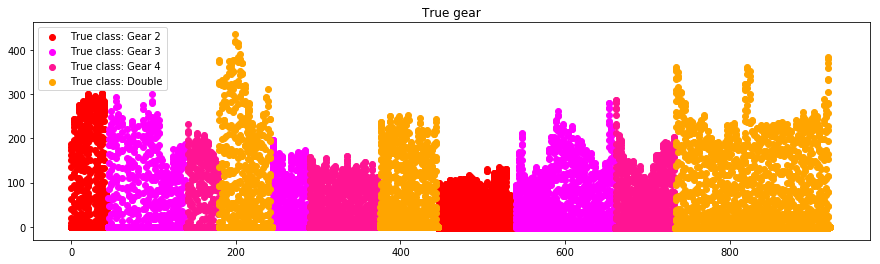

In [94]:
true_Y = np.argmax(Y_fold_list_new[0],axis = 1)
figure = plot_skiedata(true_Y,X_Plot,0)

In [17]:
def CNN_One_Layer_26():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = Conv1D(kernel_size = (5), filters = 26, activation='relu', padding = "same")(sequence_input)
    x = GlobalMaxPooling1D()(x)
    x = Dense(X.shape[1], activation='relu')(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def CNN_One_Layer_38():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = Conv1D(kernel_size = (5), filters = 38, activation='relu', padding = "same")(sequence_input)
    x = GlobalMaxPooling1D()(x)
    x = Dense(X.shape[1], activation='relu')(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
def CNN_One_Layer_52():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = Conv1D(kernel_size = (5), filters = 52, activation='relu', padding = "same")(sequence_input)
    x = GlobalMaxPooling1D()(x)
    x = Dense(X.shape[1], activation='relu')(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def CNN_One_Layer_72():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = Conv1D(kernel_size = (5), filters = 72, activation='relu', padding = "same")(sequence_input)
    x = GlobalMaxPooling1D()(x)
    x = Dense(X.shape[1], activation='relu')(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def CNN_One_Layer_126():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = Conv1D(kernel_size = (5), filters = 126, activation='relu', padding = "same")(sequence_input)
    x = GlobalMaxPooling1D()(x)
    x = Dense(X.shape[1], activation='relu')(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model



Training model: CNN_One_Layer_26
Train on 915 samples, validate on 191 samples
Epoch 1/20
915/915 [==============================] - 4s 5ms/step - loss: 7.2544 - acc: 0.4404 - val_loss: 3.7647 - val_acc: 0.4293
Epoch 2/20
915/915 [==============================] - 4s 4ms/step - loss: 2.5774 - acc: 0.6492 - val_loss: 2.6592 - val_acc: 0.7277
Epoch 3/20
915/915 [==============================] - 4s 4ms/step - loss: 2.3677 - acc: 0.7246 - val_loss: 3.6360 - val_acc: 0.4660
Epoch 4/20
915/915 [==============================] - 4s 5ms/step - loss: 2.2684 - acc: 0.7497 - val_loss: 3.2003 - val_acc: 0.5393
Epoch 5/20
915/915 [==============================] - 4s 5ms/step - loss: 2.2357 - acc: 0.7650 - val_loss: 2.7622 - val_acc: 0.6806
Epoch 6/20
915/915 [==============================] - 4s 4ms/step - loss: 2.1789 - acc: 0.7902 - val_loss: 2.6374 - val_acc: 0.7382
Epoch 7/20
915/915 [==============================] - 4s 4ms/step - loss: 2.1803 - acc: 0.7934 - val_loss: 2.8347 - val_acc: 0.66

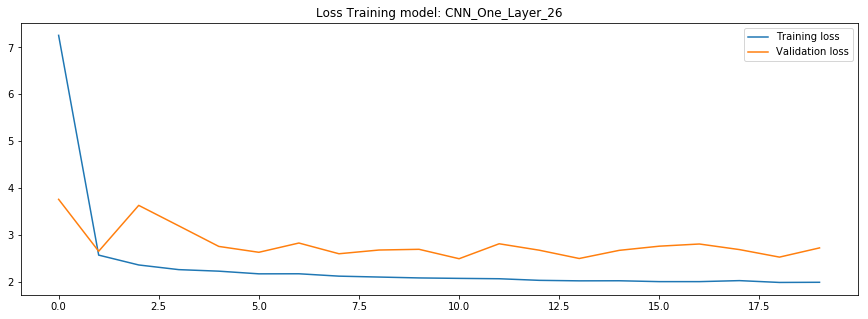

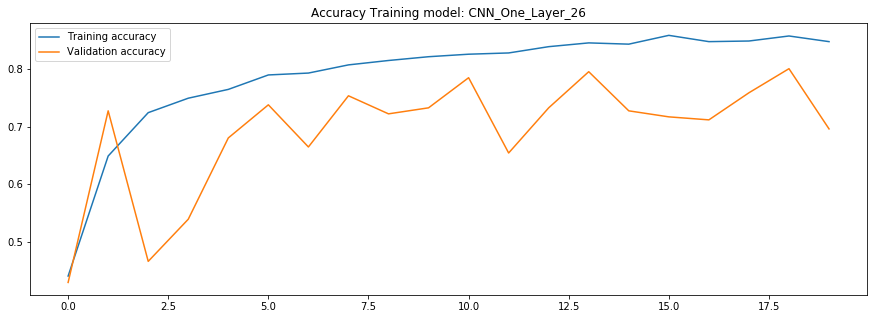

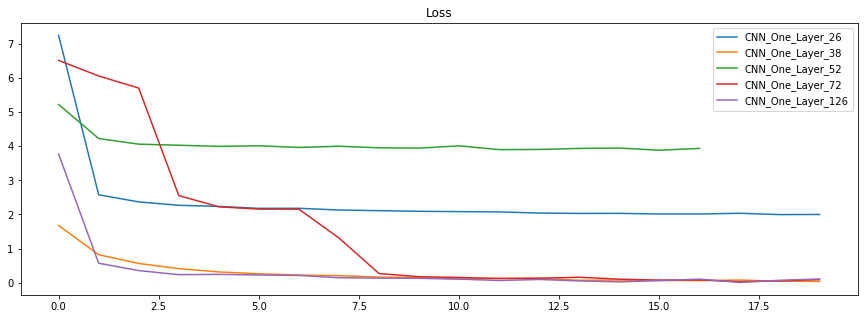

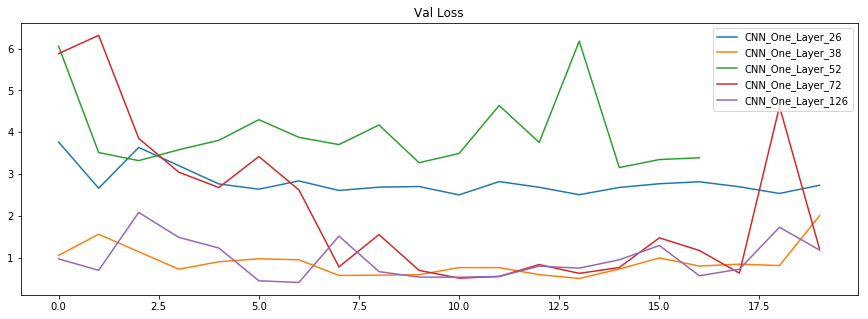

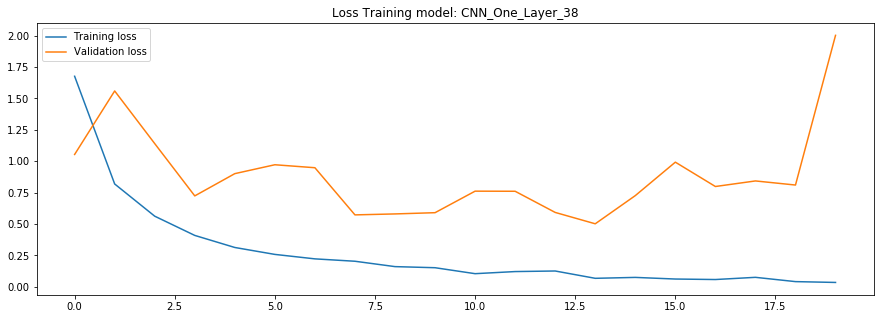

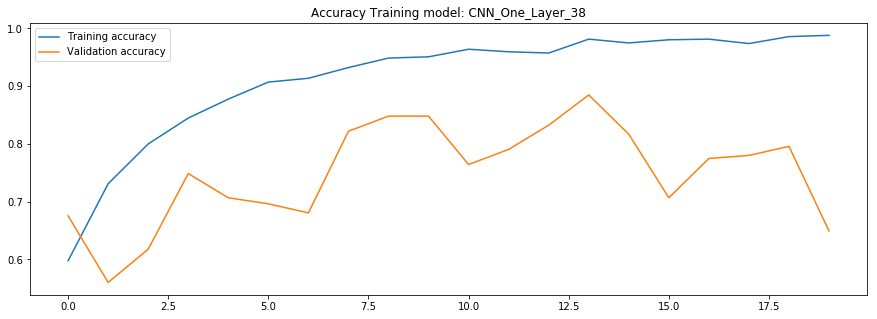

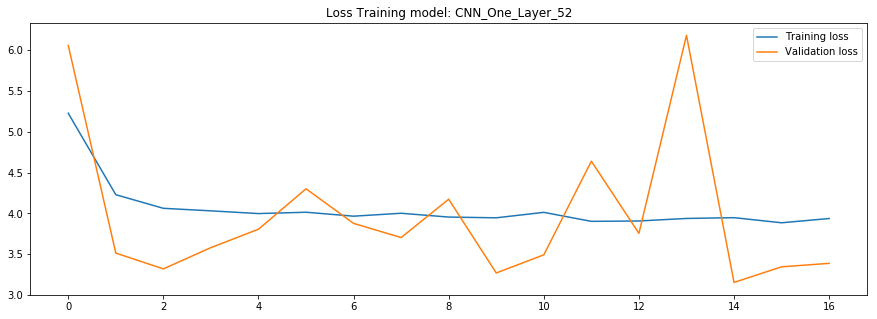

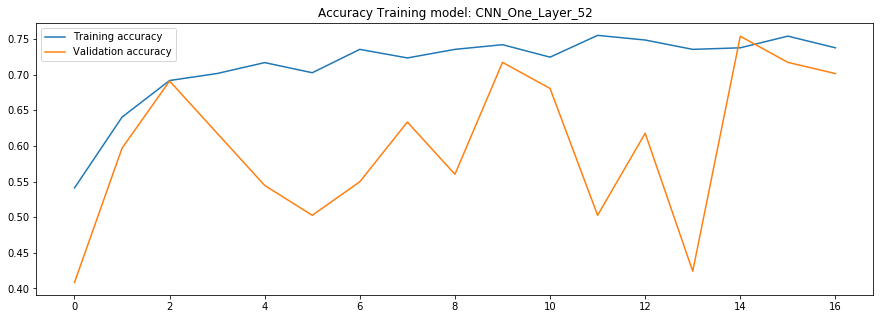

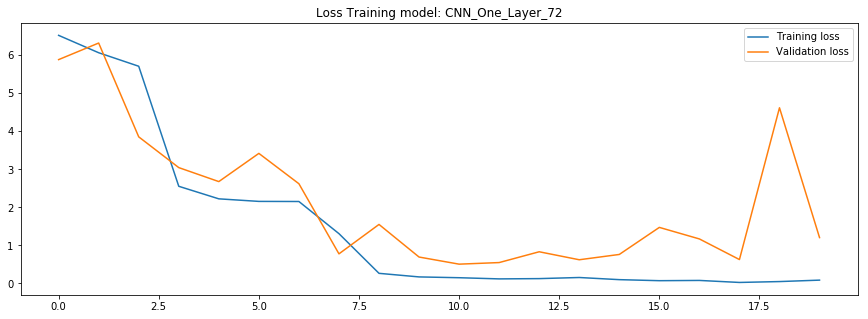

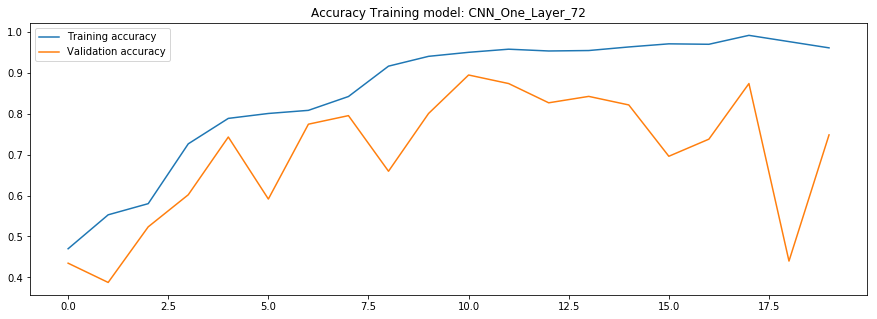

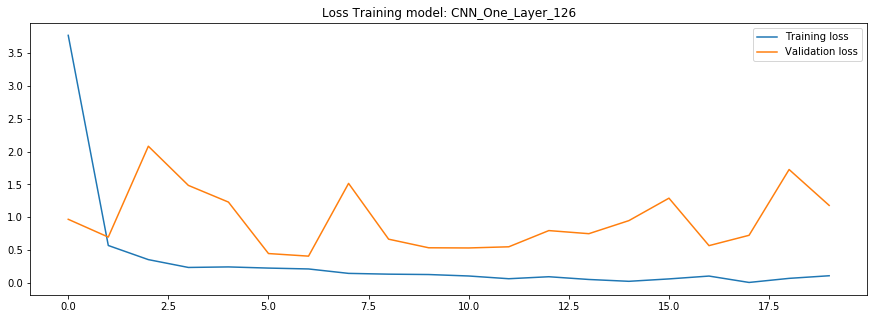

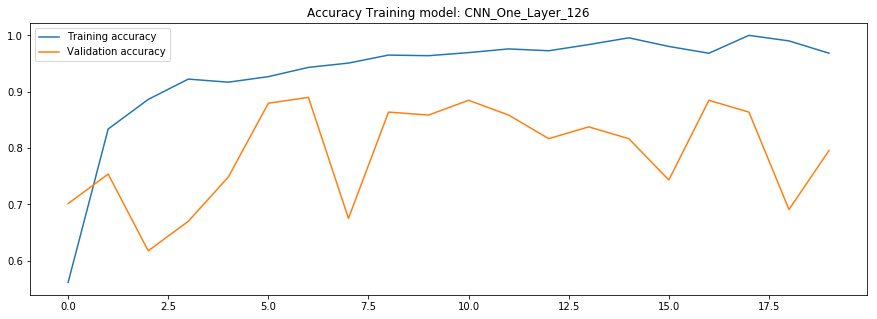

In [45]:
model_names = ['CNN_One_Layer_26','CNN_One_Layer_38','CNN_One_Layer_52','CNN_One_Layer_72','CNN_One_Layer_126']
eS = EarlyStopping(monitor='acc', min_delta=0.00001, patience=5)
i = 0
for name in model_names:
    print('Training model:',name)
    model = globals()[name]()
    #tb = TensorBoard(log_dir='./logs/'+name)
    history = model.fit(X[:,:,1:], Y, epochs=20, batch_size=1, validation_data=(X_Val[:,:,1:],Y_Val),shuffle = True,callbacks = [eS])
    print('Done!')
    plt.figure(2*i,[15,5])
    plt.title('Loss Training model: ' + name)
    plt.plot(history.history['loss'],label = 'Training loss')
    plt.plot(history.history['val_loss'],label = 'Validation loss')
    plt.legend()
    plt.figure(2*i + 1,[15,5])
    plt.plot(history.history['acc'],label = 'Training accuracy')
    plt.plot(history.history['val_acc'],label = 'Validation accuracy')
    plt.title('Accuracy Training model: ' + name)
    plt.legend()
    plt.figure(2*len(model_names),[15,5])
    plt.title('Loss')
    plt.plot(history.history['loss'],label = name)
    plt.legend()
    plt.figure(2*len(model_names) + 1,[15,5])
    plt.title('Val Loss')
    plt.plot(history.history['val_loss'],label = name)
    plt.legend()

    i = i + 1 

In [52]:
def CNN_Two_Layer_26():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = Conv1D(kernel_size = (5), filters = 26, activation='relu', padding = "same")(sequence_input)
    x = MaxPooling1D(5)(x)
    x = Conv1D(kernel_size = (5), filters = 26, activation='relu', padding = "same")(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(X.shape[1], activation='relu')(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def CNN_Two_Layer_52():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = Conv1D(kernel_size = (5), filters = 52, activation='relu', padding = "same")(sequence_input)
    x = MaxPooling1D(5)(x)
    x = Conv1D(kernel_size = (5), filters = 52, activation='relu', padding = "same")(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(X.shape[1], activation='relu')(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [53]:
model = CNN_Two_Layer_52()
eS = EarlyStopping(monitor='acc', min_delta=0.00001, patience=5)
mCp = ModelCheckpoint('CNN_1_2_3_New_Preprocessing_here.h5', monitor='val_loss', save_best_only=True)
history = model.fit(X[:,:,1:], Y, epochs=10, batch_size=1, validation_data=(X_val[:,:,1:],Y_val),shuffle = True,callbacks = [eS,mCp])

Train on 1341 samples, validate on 165 samples
Epoch 1/10
1341/1341 [==============================] - 7s 5ms/step - loss: 1.7351 - acc: 0.7256 - val_loss: 0.8090 - val_acc: 0.7394
Epoch 2/10
1341/1341 [==============================] - 6s 4ms/step - loss: 0.2890 - acc: 0.9038 - val_loss: 0.4756 - val_acc: 0.8606
Epoch 3/10
1341/1341 [==============================] - 6s 5ms/step - loss: 0.1452 - acc: 0.9500 - val_loss: 0.3891 - val_acc: 0.8788
Epoch 4/10
1341/1341 [==============================] - 6s 5ms/step - loss: 0.1091 - acc: 0.9545 - val_loss: 0.5057 - val_acc: 0.8545
Epoch 5/10
1341/1341 [==============================] - 6s 5ms/step - loss: 0.1324 - acc: 0.9635 - val_loss: 0.3210 - val_acc: 0.9333
Epoch 6/10
1341/1341 [==============================] - 6s 4ms/step - loss: 0.0461 - acc: 0.9814 - val_loss: 0.4424 - val_acc: 0.8485
Epoch 7/10
1341/1341 [==============================] - 6s 4ms/step - loss: 0.0493 - acc: 0.9814 - val_loss: 0.3280 - val_acc: 0.8909
Epoch 8/10
1341

In [54]:
from keras.models import load_model
model = load_model('CNN_1_2_3_New_Preprocessing_here.h5')
predY = model.predict(X_val[:,:,1:])
print(predY.shape)
pred_Y = np.argmax(predY,axis = 1)
true_Y = np.argmax(Y_val,axis = 1)
acc = accuracy_score(true_Y,pred_Y)
print("Accuracy: %.2f" % acc)

(165, 4)
Accuracy: 0.93


In [127]:
x_list = [[1,2,3,4],[0,2,3,4],[0,1,3,4],[0,1,2,4],[0,1,2,3]]
X_train_list = [X_fold_list_new[i] for i in x_list[0]]
X_train = np.concatenate(X_train_list, axis=0)
print(X_train.shape)

(1342, 140, 17)


In [128]:
print(folds)

5


In [130]:
cros_val_acc = 0
for fold in range(folds):
    x_list = [[1,2,3,4],[0,2,3,4],[0,1,3,4],[0,1,2,4],[0,1,2,3]]
    X_train_list = [X_fold_list_new[i] for i in x_list[fold]]
    Y_train_list = [Y_fold_list_new[i] for i in x_list[fold]]

    X_train = np.concatenate(X_train_list, axis=0)
    Y_train = np.concatenate(Y_train_list, axis=0)
    X_val = X_fold_list_new[fold]
    Y_val = Y_fold_list_new[fold]

    model = CNN_Two_Layer_52()
    eS = EarlyStopping(monitor='acc', min_delta=0.00001, patience=3)
    mCp = ModelCheckpoint('CNN_1_2_3_New_Preprocessing_fold_' +str(fold) +'.h5', monitor='val_loss', save_best_only=True)
    history = model.fit(X_train[:,:,1:], Y_train, epochs=20, batch_size=1, validation_data=(X_val[:,:,1:],Y_val),shuffle = True,callbacks = [eS,mCp])
    model = load_model('CNN_1_2_3_New_Preprocessing_fold_' +str(fold) +'.h5')
    predY = model.predict(X_val[:,:,1:])
    print(predY.shape)
    pred_Y = np.argmax(predY,axis = 1)
    true_Y = np.argmax(Y_val,axis = 1)
    acc = accuracy_score(true_Y,pred_Y)
    print("Accuracy: %.2f" % acc)
    
    cros_val_acc = cros_val_acc + acc
    
#print("Cross accuracy: %.2f" % cros_val_accc/5)

Train on 1342 samples, validate on 329 samples
Epoch 1/20
1342/1342 [==============================] - 11s 8ms/step - loss: 1.1214 - acc: 0.6662 - val_loss: 0.3903 - val_acc: 0.8845
Epoch 2/20
1342/1342 [==============================] - 7s 5ms/step - loss: 0.2776 - acc: 0.8994 - val_loss: 0.3329 - val_acc: 0.8997
Epoch 3/20
1342/1342 [==============================] - 7s 6ms/step - loss: 0.1824 - acc: 0.9389 - val_loss: 0.2167 - val_acc: 0.9453
Epoch 4/20
1342/1342 [==============================] - 7s 5ms/step - loss: 0.1290 - acc: 0.9538 - val_loss: 0.2359 - val_acc: 0.9271
Epoch 5/20
1342/1342 [==============================] - 7s 5ms/step - loss: 0.1018 - acc: 0.9702 - val_loss: 0.2406 - val_acc: 0.9362
Epoch 6/20
1342/1342 [==============================] - 7s 5ms/step - loss: 0.0754 - acc: 0.9747 - val_loss: 0.1846 - val_acc: 0.9574
Epoch 7/20
1342/1342 [==============================] - 7s 5ms/step - loss: 0.0744 - acc: 0.9769 - val_loss: 0.3296 - val_acc: 0.9058
Epoch 8/20
134

1316/1316 [==============================] - 8s 6ms/step - loss: 5.6428 - acc: 0.6497 - val_loss: 6.0325 - val_acc: 0.5803
Epoch 9/20
1316/1316 [==============================] - 8s 6ms/step - loss: 5.6544 - acc: 0.6421 - val_loss: 5.8687 - val_acc: 0.6141
Epoch 10/20
1316/1316 [==============================] - 8s 6ms/step - loss: 5.6500 - acc: 0.6467 - val_loss: 5.8469 - val_acc: 0.6141
Epoch 11/20
1316/1316 [==============================] - 8s 6ms/step - loss: 5.6357 - acc: 0.6497 - val_loss: 5.8250 - val_acc: 0.6113
(355, 4)
Accuracy: 0.61


In [132]:
c = cros_val_acc/5
print("Accuracy: %.2f" % c)

Accuracy: 0.90


In [133]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 140, 16)           0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 140, 52)           4212      
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 28, 52)            0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 28, 52)            13572     
_________________________________________________________________
global_max_pooling1d_23 (Glo (None, 52)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 140)               7420      
_________________________________________________________________
dense_46 (Dense)             (None, 4)                 564       
Total para